In [1]:
import math
import pandas as pd
import numpy as np # numerical tools
from numpy.random import Generator, PCG64
import itertools
from scipy.stats import poisson as psn
from scipy.stats import gamma as gamma
import matplotlib.pyplot as plt
import statistics

In [2]:
'''
Versions used in Analysis
Python 3.10.6
pandas 1.4.4
numpy 1.23.2
scipy 1.9.1
matplotlib 3.5.3
'''

'\nVersions used in Analysis\nPython 3.10.6\npandas 1.4.4\nnumpy 1.23.2\nscipy 1.9.1\nmatplotlib 3.5.3\n'

In [3]:
df = pd.read_csv('GCS_table.txt', header=36, sep="\s+", skip_blank_lines=False, na_values='nd')
df.head()

,Galaxy,OtherID,RA,DEC,Type,D,D+-,Method,A_V,M_V^T,...,lgM_B+,lgM_B-,hr,deg,Mpc,km/s,kpc,M_sun,M_sun.1,M_sun.2
0,MilkyWay,nid,NaN,NaN,Sbc,NaN,NaN,geometry,0.000,-21.30,...,0.04,0.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,WLM,DDO-221,0.032838,-15.460928,Irr,1.00,0.10,TRGB/Cepheid,0.088,-14.84,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NGC7814,nid,0.054144,16.145548,Sab,13.18,0.88,SBF,0.147,-20.18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NGC55,nid,0.248224,-39.196582,SBm,2.09,0.08,TRGB/Cepheid,0.036,-18.77,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NGC147,nid,0.553330,48.508600,E5,0.76,0.10,TRGB/SBF,0.475,-15.46,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# data of interest
Mv = df['M_V^T'] # Absolute visual magnitude of galaxy
NGC = df['N(GC)'] # Estimated total number of globular clusters in the galaxy

# Dataset Summary

Text(0, 0.5, 'Counts')

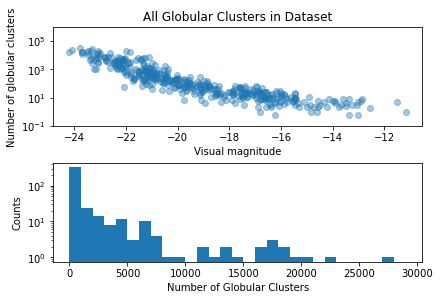

In [5]:
# plot number of globular clusters by visual magnitude
fig, ax = plt.subplots(2, layout='constrained')
ax[0].scatter(Mv, NGC, alpha=0.4)
ax[0].set_xlabel("Visual magnitude")
ax[0].set_ylabel("Number of globular clusters")
ax[0].set_yscale('log')
ax[0].set_ylim(0.1, 1000000)
ax[0].set_title('All Globular Clusters in Dataset')

ax[1].hist(NGC, bins=np.arange(0, 30000, 1000))
ax[1].set_yscale('log')
ax[1].set_xlabel('Number of Globular Clusters')
ax[1].set_ylabel('Counts')

Sample Mean:  3.4692307692307693
Sample Variance:  9.430641025641025


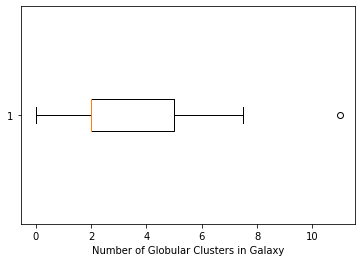

In [6]:
maglimup,maglimlow = (-14,-15)
N = np.array([NGC[i] for i,item in enumerate(Mv) if (item <=maglimup and item>=maglimlow and math.isnan(NGC[i]) == False)]) # Number of GC in galaxy if galaxy brighter than -20 mags
M = np.array([item for i,item in enumerate(Mv) if (item <=maglimup and item>=maglimlow and math.isnan(NGC[i]) == False)]) # Magnitueds brighter than -20 mags

plt.boxplot(N,vert=False)
plt.xlabel('Number of Globular Clusters in Galaxy')

print('Sample Mean: ',np.mean(N))
print('Sample Variance: ', statistics.variance(N))

# Analysis
For our Poisson model, we assume that the mean value of globular clusters per galaxy $\theta \sim \mathrm{Gamma}(a = 16, b = 4)$.

In [7]:
# Looking between -14 and -15 in Mv
maglimup,maglimlow = (-14,-15)
N = np.array([NGC[i] for i,item in enumerate(Mv) if (item <=maglimup and item>=maglimlow and math.isnan(NGC[i]) == False)]) # Number of GC in galaxy if galaxy brighter than -20 mags
M = np.array([item for i,item in enumerate(Mv) if (item <=maglimup and item>=maglimlow and math.isnan(NGC[i]) == False)]) # Magnitueds brighter than -20 mags

# Function returns prior, posterior, means, and post. variance.
def dostats(data,alpha,beta):
    # Alpha is shape parameter, Beta is rate parameter
    a = alpha + sum(data) # Shape for Posterior
    b = beta + len(data) # Rate for posterior

    xd = np.arange(0, np.max(data), 0.1)
    prior = gamma.pdf(xd,alpha,scale=1/beta) # Conjugate Prior is Gamma function
    posterior = gamma.pdf(xd,a,scale=1/b)

    priormean = alpha/beta
    posteriormean = a/b
    postvar = a/(b**2)

    return xd,prior,posterior,priormean,posteriormean,postvar,a,b

Mean N_GC: 3.5941176470588236


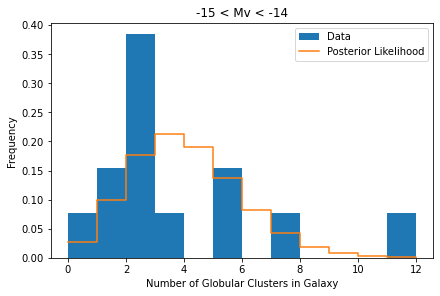

In [8]:

testalpha=16
testbeta=4

xrang,prior,posterior,primean,postmean,postvar,apost,bpost = dostats(N,testalpha,testbeta)
print('Mean N_GC:',postmean)

idxmax = np.argmax(posterior)
xmax = xrang[idxmax]
x = np.arange(0, 13, 1)
y = psn.pmf(x, postmean)

fig, ax = plt.subplots(1, layout='constrained')
ax.hist(N, bins = x, density=True, label='Data')
ax.step(x,y,where='post',label='Posterior Likelihood')
# bin_center = 0.5*(bins[1:] + bins[:-1])

ax.set_title('%s < Mv < %s'%(int(maglimlow),int(maglimup)))
ax.set_xlabel("Number of Globular Clusters in Galaxy")
ax.set_ylabel('Frequency')
ax.legend()


2.749859312864928 3.5941176470588236 4.549673843896447


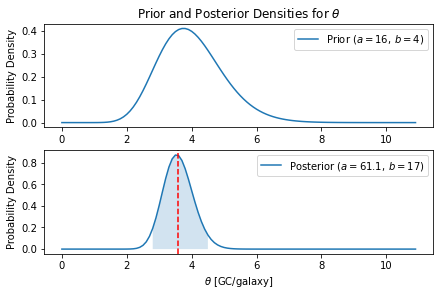

In [9]:
fig, ax = plt.subplots(2, layout='constrained')
ax[0].set_title(r'Prior and Posterior Densities for $\theta$')
ax[0].plot(xrang, prior, 
    label=r'Prior $(a = {},\, b = {})$'.format(testalpha, testbeta))
ax[0].set_ylabel("Probability Density")
ax[0].legend()

ax[1].plot(xrang, posterior, 
    label='Posterior $(a = {},\, b = {})$'.format(apost, bpost))
ax[1].set_ylabel("Probability Density")
ax[1].set_xlabel(r'$\theta$ [GC/galaxy]')
ax[1].legend()

# confidence interval
min = gamma.ppf(0.025, apost, scale=1/bpost)
max = gamma.ppf(0.975, apost, scale=1/bpost)
ax[1].fill_between(xrang, 0, posterior, 
    where=(xrang > min) & (xrang < max),
    alpha = 0.2
    )
ax[1].axvline(x = postmean, color = 'r', linestyle='--')

print(min, postmean, max)


# Prior Predictive Test

Text(0.5, 1.0, 'Observed Data and Prior Prediction')

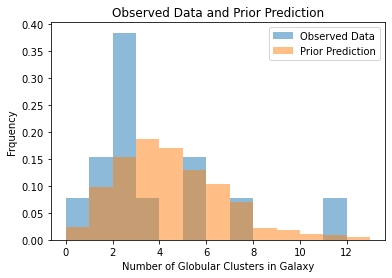

In [10]:
# Now let's check a prior predictive test
maglimup,maglimlow = (-14,-15)
N = np.array([NGC[i] for i,item in enumerate(Mv) if (item <=maglimup and item>=maglimlow and math.isnan(NGC[i]) == False)])

# seed random number generators
randTheta = gamma
randX = psn
randTheta.random_state = Generator(PCG64(5731))
randX.random_state = Generator(PCG64(5731))

# MC simulation
m=1000
sample_pred = []
for j in range(m):
    thetapred = randTheta.rvs(testalpha,scale=1/testbeta,size=1)[0]
    xj = randX.rvs(thetapred,size=1)[0]
    sample_pred.append(xj)

# plot results
plt.hist(N, bins=np.arange(0, 14), density=True,alpha=0.5,label='Observed Data')
plt.hist(sample_pred, bins=np.arange(0, 14), density=True, alpha=0.5, label='Prior Prediction')
plt.xlabel("Number of Globular Clusters in Galaxy")
plt.ylabel("Frquency")
plt.legend()
plt.title('Observed Data and Prior Prediction')


# Sensitivity Analysis

1.6887571747795538 2.2975609756097564 2.998627806893238
2.6236441311156105 3.506666666666667 4.515802459876865
2.41166545134969 3.292857142857143 4.309143722147251
2.479806026167423 3.3400000000000003 4.3262984968733615
2.530147726039116 3.4673328209069947 4.54988782867669
2.2173281792639465 3.00625 3.9133876427101226
2.30796813886539 3.14 4.098124669420758
5.3239873837101745 6.308695652173912 7.375724133867452
8.746550701809573 10.364285714285714 12.117261077067957


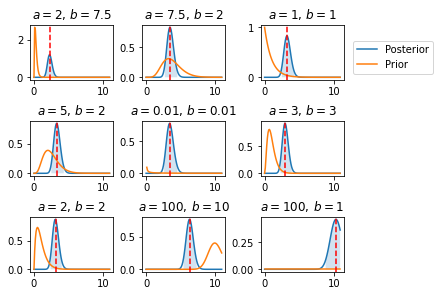

In [11]:
priors = [[2, 7.5], [7.5, 2], [1, 1], [5, 2],[0.01,0.01],[3,3],[2,2], [100, 10], [100, 1]]
fig, axes = plt.subplots(3, 3, constrained_layout=True)

maglimup,maglimlow = (-14,-15)
N = np.array([NGC[i] for i,item in enumerate(Mv) if (item <=maglimup and item>=maglimlow and math.isnan(NGC[i]) == False)])

i = 0
for ax in (axes.flat):
    xrang,prior,posterior,primean,postmean,postvar,aPost,bPost = dostats(N,priors[i][0],priors[i][1])

    # confidence interval for normal
    min = gamma.ppf(0.025, aPost, scale=1/bPost)
    max = gamma.ppf(0.975, aPost, scale=1/bPost)
    print(min, postmean, max)

    ax.plot(xrang, posterior, label="Posterior")

    ax.plot(xrang, prior, label="Prior")
    ax.set_title(r"$a = {},\, b = {}$".format(priors[i][0], priors[i][1]))
    ax.fill_between(xrang, 0, posterior, 
        where=(xrang > min) & (xrang < max),
        alpha = 0.2
        )
    ax.axvline(x = postmean, color = 'r', linestyle='--')

    if i == 2: ax.legend(bbox_to_anchor = (1.05, 0.8))

    i += 1